### PREPARATION

In [120]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy
import sys

In [121]:
uhs = pypsa.Network("../../../pypsa-earth/results/UHS/postnetworks/elec_s_24_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
woUHS = pypsa.Network("../../../pypsa-earth/results/woUHS/postnetworks/elec_s_24_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")
regions_onshore = gpd.read_file("../../../pypsa-earth/resources/shapes/country_shapes.geojson")
SCENARIO_COLORS = {"UHS": "#1f77b4", "woUHS": "#ff7f0e"}

INFO:pypsa.io:Imported network elec_s_24_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_24_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [122]:
# uhs1 = pypsa.Network("results/UHS1/postnetworks/elec_s_1_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
# woUHS1 = pypsa.Network("results/woUHS1/postnetworks/elec_s_1_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")
# uhs10 = pypsa.Network("results/UHS10/postnetworks/elec_s_10_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
# woUHS10 = pypsa.Network("results/woUHS10/postnetworks/elec_s_10_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")
# uhs100 = pypsa.Network("results/UHS100/postnetworks/elec_s_100_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
# woUHS100 = pypsa.Network("results/woUHS100/postnetworks/elec_s_100_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")
# uhswotm = pypsa.Network("results/UHSwotm/postnetworks/elec_s_24_ec_lcopt_Co2L0.15-3h_3h_2050_0.094_NZ_199.8export.nc")
# woUHSwotm = pypsa.Network("results/woUHSwotm/postnetworks/elec_s_24_ec_lcopt_Co2L0.15_3H_2050_0.094_NZ_199.8export.nc")

#### Show initial energy system design

In [123]:
# Plot energy system on map right now, another two subplots with energy carriers in a pie chart and storages in a pie chart

#### Compare energy system with uhs and without

In [124]:
# Plot a map with all bus regions seperated and mark the one with UHS in a different color / or plot capacities of UHS
uhs.stores[uhs.stores.carrier == "H2 UHS"]

,bus,carrier,e_nom_extendable,e_cyclic,capital_cost,e_initial,e_min_pu,e_nom,e_nom_max,lifetime,...,e_nom_min,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,marginal_cost_quadratic,marginal_cost_storage,build_year
Store,,,,,,,,,,,,,,,,,,,,,
TN.10_1_AC H2 UHS,TN.10_1_AC H2 UHS,H2 UHS,True,True,89.430064,0.0,0.0,0.0,1.000000e+09,100.0,...,0.0,1.0,False,True,0.0,0.0,1.0,0.0,0.0,0
TN.21_1_AC H2 UHS,TN.21_1_AC H2 UHS,H2 UHS,True,True,89.430064,0.0,0.0,0.0,1.000000e+09,100.0,...,0.0,1.0,False,True,0.0,0.0,1.0,0.0,0.0,0
TN.22_1_AC H2 UHS,TN.22_1_AC H2 UHS,H2 UHS,True,True,89.430064,0.0,0.0,0.0,1.000000e+09,100.0,...,0.0,1.0,False,True,0.0,0.0,1.0,0.0,0.0,0


In [125]:
# Plot energy system uhs and woUHS 2050 on a map next to each other

In [126]:
# Plot electrolyzer capacities on a map for uhs and woUHS 2050 next to each other

In [127]:
# Plot bar charts of capacity extension of energy carriers, storages and use of hydrogen for uhs and woUHS 2050 next to each other

In [128]:
# Plot energy balance of uhs and woUHS 2050 next to each other

##### Energy Balance

In [129]:
def compute_energy_balance(n: pypsa.Network) -> pd.DataFrame:
    rename_cols = {
        "-": "Load",
        "load": "load shedding",
    }

    energy_balance = (
        n.statistics.energy_balance()      
        .loc[:, :, "AC"]                   
        .groupby("carrier")
        .sum()
        .div(1e6)                          
        .to_frame()
        .T
        .rename(columns=rename_cols)
    )

    # Ensure only non-zero columns stay (optional; comment out if you want all)
    energy_balance = energy_balance.loc[:, (energy_balance != 0).any(axis=0)]
    return energy_balance

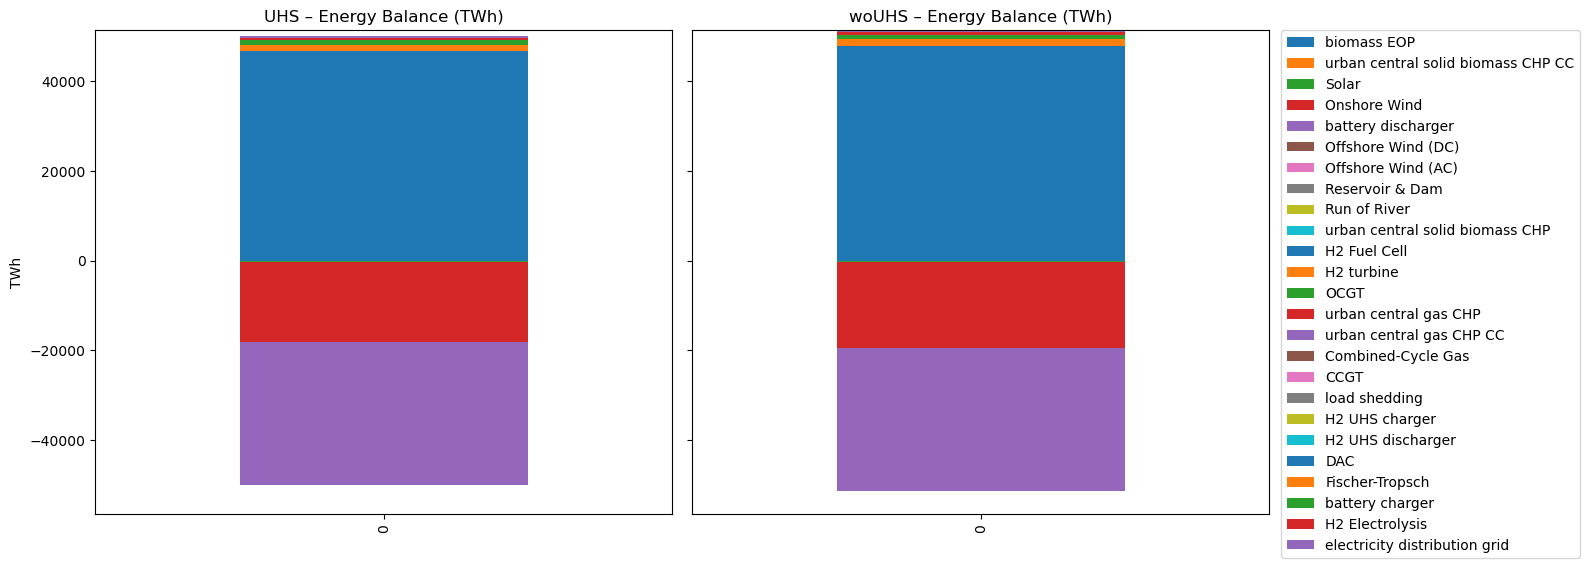

In [130]:
df_uhs = compute_energy_balance(uhs)
df_wouhs = compute_energy_balance(woUHS)

# - Harmonize columns and order them consistently -
all_cols = sorted(set(df_uhs.columns) | set(df_wouhs.columns))
df_uhs = df_uhs.reindex(columns=all_cols, fill_value=0)
df_wouhs = df_wouhs.reindex(columns=all_cols, fill_value=0)

# Order columns by combined magnitude (largest first) for easier comparison
order = (df_uhs.add(df_wouhs, fill_value=0)).iloc[0].sort_values(ascending=False).index.tolist()
df_uhs = df_uhs[order]
df_wouhs = df_wouhs[order]

# - Plot side-by-side subplots (stacked bars) -
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

df_uhs.plot.bar(stacked=True, ax=axes[0], legend=False, title="UHS – Energy Balance (TWh)")
axes[0].set_xlabel("")
axes[0].set_ylabel("TWh")

df_wouhs.plot.bar(stacked=True, ax=axes[1], legend=True, title="woUHS – Energy Balance (TWh)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Put the legend outside the second subplot
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()

In [156]:
# plot only hydrogen energy balances next to each other
uhs.statistics.energy_balance().loc[:,:,"H2"]
woUHS.statistics.energy_balance().loc[:,:,"H2"]

component  carrier                 
Link       Fischer-Tropsch            -1.141910e+08
           H2 Electrolysis             1.342671e+10
           H2 Fuel Cell               -1.507452e+02
           H2 turbine                 -1.395529e+02
           SMR                         1.207042e+02
           SMR CC                      1.007206e+02
           Sabatier                   -1.311116e+10
Generator  load                        8.968000e-02
Load       H2                         -1.998000e+08
           H2 for shipping            -3.245200e+04
           land transport fuel cell   -1.530445e+06
dtype: float64

In [132]:
# Plot heating and transport supply distribution 2050 of uhs and woUHS next to each other

##### Heating Supply Distribution

/tmp/ipykernel_1839339/376518694.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_1839339/376518694.py:49: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



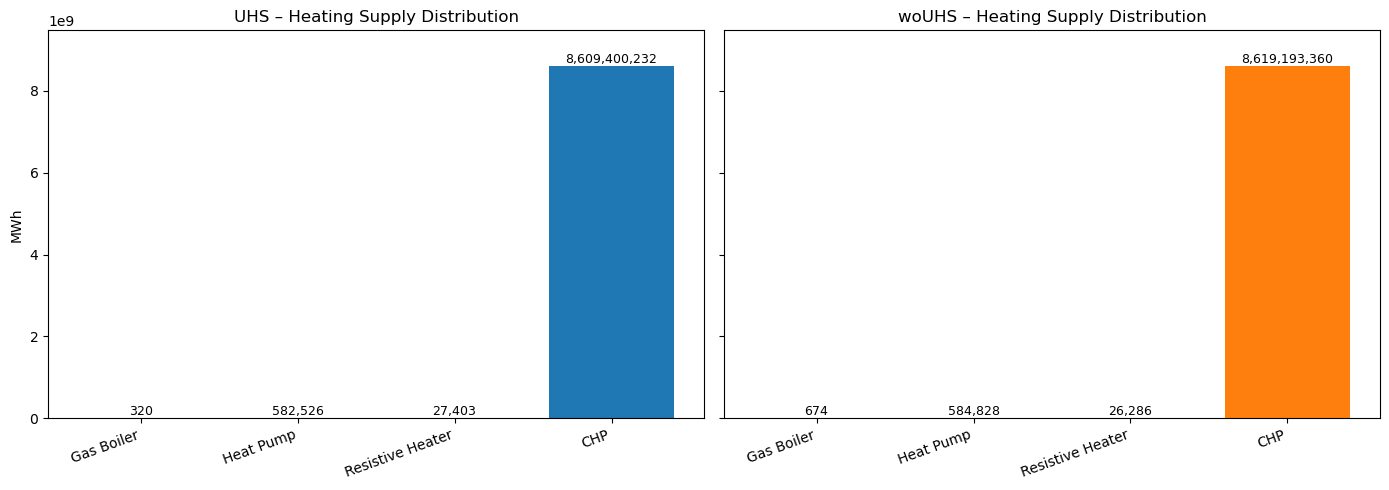

In [133]:
# Define which heating technologies to report (match by substring, case-insensitive) 
heating_types = ["Gas Boiler", "Heat Pump", "Resistive Heater", "CHP"]

def heating_distribution(n: pypsa.Network, tech_labels=heating_types):
    """
    Returns a Series indexed by tech_labels with MWh totals for each label.
    Matches each label against the 'carrier' level (case-insensitive).
    """
    # Aggregate supply for Links over the full time horizon
    s = (
        n.statistics.supply(comps=["Link"], aggregate_time="sum")
        .loc[lambda x: x.index.get_level_values("carrier").str.contains("heat|boiler|pump|chp", case=False)]
    )

    # Helper: sum all rows whose 'carrier' contains a keyword
    def sum_for(keyword: str) -> float:
        mask = s.index.get_level_values("carrier").str.contains(keyword, case=False, na=False)
        if not mask.any():
            return 0.0
        # Sum across all matching rows and all columns -> scalar (MWh)
        return float(s.loc[mask].sum(numeric_only=True).sum())

    data = {label: sum_for(label) for label in tech_labels}
    return pd.Series(data, index=tech_labels)

# Compute totals (MWh)
uhs_mwh = heating_distribution(uhs)
wouhs_mwh = heating_distribution(woUHS)

#  Combine for consistent order and to keep zeros explicit 
df = pd.DataFrame({"UHS": uhs_mwh, "woUHS": wouhs_mwh})

# Optional: convert to TWh for readability (uncomment next line if desired)
# df = df / 1e6

#  Plot side-by-side bar charts 
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: UHS
axes[0].bar(df.index, df["UHS"], color=SCENARIO_COLORS["UHS"])
axes[0].set_title("UHS – Heating Supply Distribution")
axes[0].set_ylabel("MWh")  # change to "TWh" if you converted above
axes[0].set_xticklabels(df.index, rotation=20, ha="right")

# Right: woUHS
axes[1].bar(df.index, df["woUHS"], color=SCENARIO_COLORS["woUHS"])
axes[1].set_title("woUHS – Heating Supply Distribution")
axes[1].set_ylabel("")  # shared y-axis
axes[1].set_xticklabels(df.index, rotation=20, ha="right")

# Make y-limits identical for fair visual comparison
ymax = max(df.values.max(), 1)
axes[0].set_ylim(0, ymax * 1.10)
axes[1].set_ylim(0, ymax * 1.10)

# Add simple value labels on bars
def add_labels(ax, values):
    for x, v in enumerate(values):
        ax.text(x, v, f"{v:,.0f}", va="bottom", ha="center", fontsize=9, rotation=0)

add_labels(axes[0], df["UHS"].values)
add_labels(axes[1], df["woUHS"].values)

plt.tight_layout()
plt.show()

##### Transport Supply Distribution

/tmp/ipykernel_1839339/3811673988.py:55: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_1839339/3811673988.py:60: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



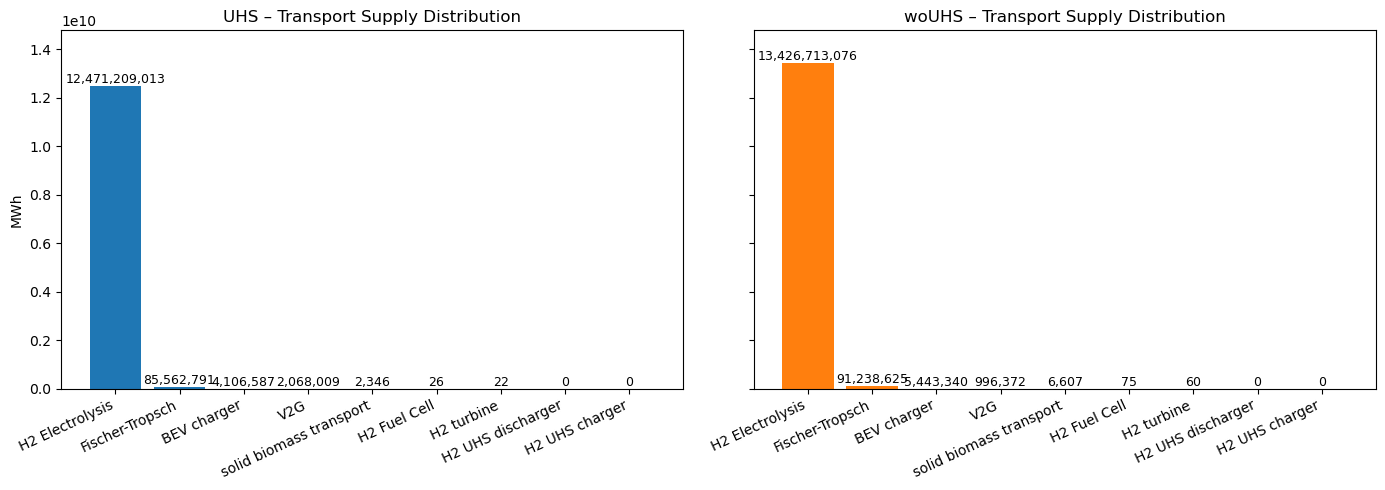

In [134]:
# Only the mentioned technologies below are considered here
transport_types = [
    "BEV charger",
    "V2G",
    "H2 Fuel Cell",
    "H2 turbine",
    "H2 Electrolysis",
    "H2 UHS charger",
    "H2 UHS discharger",
    "Fischer-Tropsch",
    "solid biomass transport",
]

def transport_distribution(n: pypsa.Network, tech_labels=transport_types) -> pd.Series:
    """
    Aggregate transport-related supply from Link components (MWh totals per label).
    Each label matches rows whose index 'carrier' contains that label (case-insensitive).
    """
    s = (
        n.statistics.supply(comps=["Link"], aggregate_time="sum")
        # keep only rows that look like transport-ish carriers to speed things up
        .loc[lambda x: x.index.get_level_values("carrier").str.contains(
            "bev|v2g|h2|fischer|biomass|transport|turbine|fuel cell|electrolysis|uhs",
            case=False, na=False
        )]
    )

    def sum_for(keyword: str) -> float:
        mask = s.index.get_level_values("carrier").str.contains(keyword, case=False, na=False)
        if not mask.any():
            return 0.0
        # sum across matching rows and all numeric columns -> scalar MWh
        return float(s.loc[mask].sum(numeric_only=True).sum())

    return pd.Series({label: sum_for(label) for label in tech_labels}, index=tech_labels)

#  Compute totals (MWh) and harmonize order 
uhs_mwh = transport_distribution(uhs)
wouhs_mwh = transport_distribution(woUHS)
df = pd.DataFrame({"UHS": uhs_mwh, "woUHS": wouhs_mwh})

# Optional: convert to TWh for readability
# df = df / 1e6

# Order bars by combined magnitude (largest first) for easy visual comparison
order = (df.sum(axis=1)).sort_values(ascending=False).index.tolist()
df = df.loc[order]

#  Plot side-by-side bar charts (no custom colors) 
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(df.index, df["UHS"], color=SCENARIO_COLORS["UHS"])
axes[0].set_title("UHS – Transport Supply Distribution")
axes[0].set_ylabel("MWh")  # change to "TWh" if you convert above
axes[0].set_xticklabels(df.index, rotation=25, ha="right")

axes[1].bar(df.index, df["woUHS"], color=SCENARIO_COLORS["woUHS"])
axes[1].set_title("woUHS – Transport Supply Distribution")
axes[1].set_ylabel("")
axes[1].set_xticklabels(df.index, rotation=25, ha="right")

# same y-limit for fair comparison
ymax = max(df.max())
axes[0].set_ylim(0, ymax * 1.10 if ymax > 0 else 1)

# simple value labels
def add_labels(ax, vals):
    for i, v in enumerate(vals):
        ax.text(i, v, f"{v:,.0f}", va="bottom", ha="center", fontsize=9)

add_labels(axes[0], df["UHS"].values)
add_labels(axes[1], df["woUHS"].values)

plt.tight_layout()
plt.show()

#### Hydrogen prices

In [135]:
# plot LCOH, Hydrogen CAPEX & OPEX, hydrogen supply and revenue for uhs and woUHS in 2025 next to each other

##### CAPEX

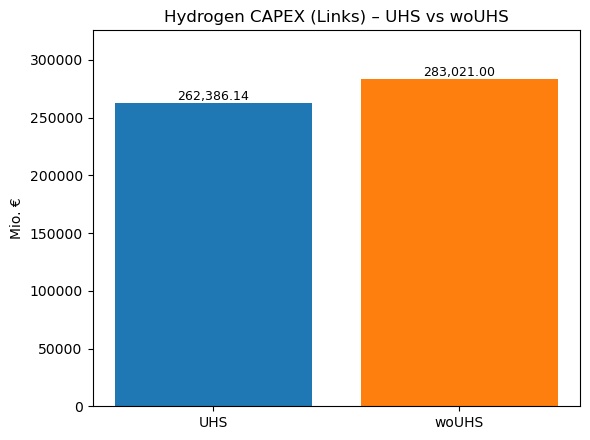

In [136]:
def hydrogen_capex_mio(n: pypsa.Network) -> float:
    """
    Sum CAPEX for hydrogen-related Links (index contains 'H2', case-insensitive).
    Works whether index is MultiIndex with 'carrier' or a simple Index.
    Returns Mio. €.
    """
    capex = n.statistics.capex(comps=["Link"])  # pandas Series of EUR
    idx = capex.index

    # Get carrier labels robustly
    if isinstance(idx, pd.MultiIndex):
        if "carrier" in (idx.names or []):
            carriers = idx.get_level_values("carrier")
        else:
            # Fall back to the last level if names aren't present
            carriers = idx.get_level_values(-1)
    else:
        carriers = pd.Index(idx)

    mask = carriers.astype(str).str.contains("H2", case=False, na=False)
    return float(capex[mask].sum()) / 1e6  # -> Mio. €

#  Compute hydrogen CAPEX (Mio. €) 
uhs_h2_capex = round(hydrogen_capex_mio(uhs), 2)
wouhs_h2_capex = round(hydrogen_capex_mio(woUHS), 2)

#  Bar plot side-by-side 
labels = ["UHS", "woUHS"]
values = [uhs_h2_capex, wouhs_h2_capex]
colors = [SCENARIO_COLORS[l] for l in labels]

fig, ax = plt.subplots(figsize=(6, 4.5))
bars = ax.bar(labels, values, color=colors)
ax.set_title("Hydrogen CAPEX (Links) – UHS vs woUHS")
ax.set_ylabel("Mio. €")
ax.set_ylim(0, max(values)*1.15 if max(values) > 0 else 1)

# Value labels
for rect, v in zip(bars, values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
            f"{v:,.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

##### OPEX

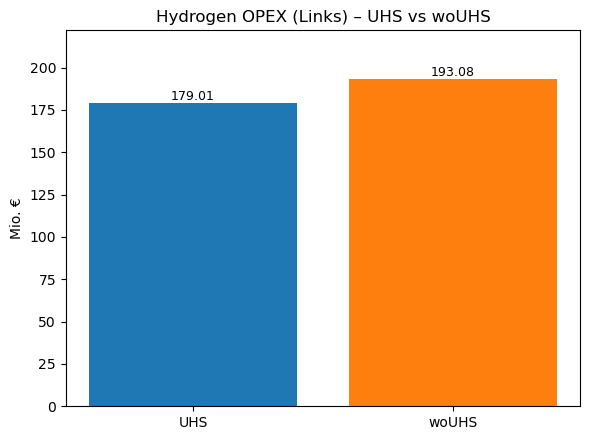

In [137]:
def hydrogen_opex_mio(n: pypsa.Network) -> float:
    """
    Sum OPEX for hydrogen-related Links (carrier contains 'H2', case-insensitive).
    Works with both MultiIndex and simple Index.
    Returns Mio. €.
    """
    opex = n.statistics.opex(comps=["Link"])  # Series of EUR
    idx = opex.index

    if isinstance(idx, pd.MultiIndex):
        if "carrier" in (idx.names or []):
            carriers = idx.get_level_values("carrier")
        else:
            carriers = idx.get_level_values(-1)
    else:
        carriers = pd.Index(idx)

    mask = carriers.astype(str).str.contains("H2", case=False, na=False)
    return float(opex[mask].sum()) / 1e6  # -> Mio. €

#  Compute hydrogen OPEX (Mio. €) 
uhs_h2_opex = round(hydrogen_opex_mio(uhs), 2)
wouhs_h2_opex = round(hydrogen_opex_mio(woUHS), 2)

#  Plot side-by-side bar chart 
labels = ["UHS", "woUHS"]
values = [uhs_h2_opex, wouhs_h2_opex]
colors = [SCENARIO_COLORS[l] for l in labels]

fig, ax = plt.subplots(figsize=(6, 4.5))
bars = ax.bar(labels, values, color=colors)
ax.set_title("Hydrogen OPEX (Links) – UHS vs woUHS")
ax.set_ylabel("Mio. €")
ax.set_ylim(0, max(values)*1.15 if max(values) > 0 else 1)

# Add value labels
for rect, v in zip(bars, values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
            f"{v:,.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

##### LCOH

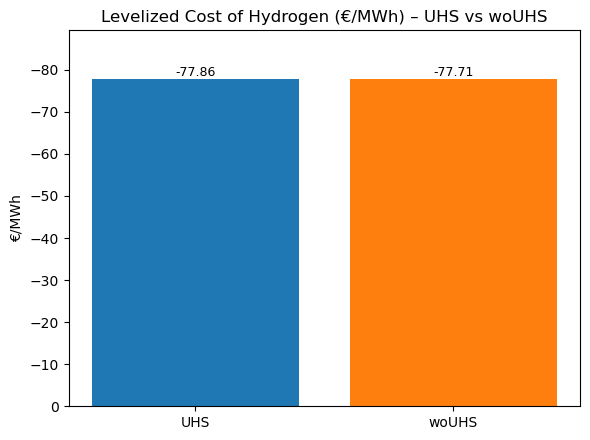

In [138]:
def _sum_matching(series_or_df, pattern: str) -> float:
    """Sum entries whose (multi)index 'carrier' (or last level) contains pattern (case-insensitive)."""
    idx = series_or_df.index
    if isinstance(idx, pd.MultiIndex):
        name_list = list(idx.names) if idx.names is not None else []
        level = "carrier" if "carrier" in name_list else idx.nlevels - 1
        carriers = idx.get_level_values(level).astype(str)
    else:
        carriers = pd.Index(idx).astype(str)
    mask = carriers.str.contains(pattern, case=False, na=False)
    return float(series_or_df.loc[mask].sum())

def _h2_capex_mio(n: pypsa.Network) -> float:
    # CAPEX (EUR) for Link entries whose carrier mentions 'H2'
    capex = n.statistics.capex(comps=["Link"])  # Series in EUR
    return _sum_matching(capex, "H2") / 1e6

def _h2_opex_mio(n: pypsa.Network) -> float:
    # OPEX (EUR) for Link entries whose carrier mentions 'H2'
    opex = n.statistics.opex(comps=["Link"])  # Series in EUR
    return _sum_matching(opex, "H2") / 1e6

def _h2_supply_mwh(n: pypsa.Network) -> float:
    # Supply (MWh) from Links whose carrier is 'H2 Electrolysis'
    # (electrolyser output is H2; adapt the pattern if your model names differ)
    supply = n.statistics.supply(comps=["Link"], aggregate_time="sum")  # DataFrame (columns by metric)
    # Some PyPSA versions return a Series—coerce to Series over all metrics if needed:
    if isinstance(supply, pd.Series):
        return _sum_matching(supply, r"^H2 Electrolysis$")
    # When DataFrame with multiple columns, sum across columns to get a scalar
    supply_series = supply.sum(axis=1, numeric_only=True)
    return _sum_matching(supply_series, r"^H2 Electrolysis$")

def _h2_electricity_cost_eur(n: pypsa.Network) -> float:
    """
    Compute electricity cost (€) to run H2 Electrolysis by multiplying each electrolyser's
    bus0 price with its electrical input (-p0), snapshot-weighted, and summing.
    """
    # Identify electrolyser links and their buses
    elec_links = n.links.index[n.links.carrier.str.fullmatch(r"H2 Electrolysis", case=False, na=False)]
    if len(elec_links) == 0:
        return 0.0

    # Prices on bus0 for each electrolyser
    bus0 = n.links.loc[elec_links, "bus0"]
    # Get marginal prices for those buses (align by snapshot)
    price_df = n.buses_t.marginal_price[bus0.values]
    price_df.columns = elec_links  # map each column to link name

    # Electrical input is -p0 (MW). Use p0 (usually <= 0 for consumption).
    p0_df = n.links_t.p0[elec_links]  # MW
    elec_consumption = -p0_df  # MW, non-negative

    # Snapshot weighting (usually hours)
    w = n.snapshot_weightings.generators  # Series indexed by snapshots

    # Elementwise multiply price (€/MWh) * consumption (MW) = €/h, then weight by hours and sum
    cost_per_snap = (price_df * elec_consumption).sum(axis=1)  # €/h assuming €/MWh * MW
    total_cost_eur = float((cost_per_snap * w).sum())
    return total_cost_eur

def compute_lcoh_eur_per_mwh(n: pypsa.Network) -> float:
    capex_mio = _h2_capex_mio(n)
    opex_mio  = _h2_opex_mio(n)
    e_cost_eur = _h2_electricity_cost_eur(n)
    supply_mwh = _h2_supply_mwh(n)

    # Convert Mio € to € for CAPEX & OPEX; keep e_cost in €
    numerator_eur = capex_mio * 1e6 + opex_mio * 1e6 + e_cost_eur
    if supply_mwh <= 0:
        return float("nan")
    return round(numerator_eur / supply_mwh, 2)

# - Compute LCOH -
lcoh_uhs = compute_lcoh_eur_per_mwh(uhs)
lcoh_wouhs = compute_lcoh_eur_per_mwh(woUHS)

# - Plot side-by-side -
labels = ["UHS", "woUHS"]
values = [lcoh_uhs, lcoh_wouhs]
colors = [SCENARIO_COLORS[l] for l in labels]

fig, ax = plt.subplots(figsize=(6, 4.5))
bars = ax.bar(labels, values, color=colors)
ax.set_title("Levelized Cost of Hydrogen (€/MWh) – UHS vs woUHS")
ax.set_ylabel("€/MWh")
ax.set_ylim(0, max(v for v in values if pd.notna(v)) * 1.15 if all(pd.notna(v) for v in values) else 1)

# value labels
for rect, v in zip(bars, values):
    if pd.notna(v):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                f"{v:,.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

##### Supply

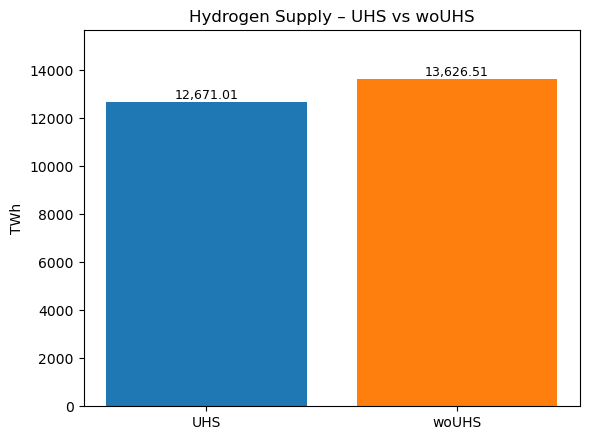

In [139]:
def hydrogen_supply_twh(n: pypsa.Network) -> float:
    """
    Sum supply for hydrogen-related Links (carrier contains 'H2').
    Returns TWh.
    """
    supply = n.statistics.supply(comps=["Link"], aggregate_time="sum")  # MWh
    idx = supply.index
    if isinstance(idx, pd.MultiIndex):
        # if multi-index, use 'carrier' if available, otherwise last level
        level = "carrier" if "carrier" in (idx.names or []) else idx.nlevels - 1
        carriers = idx.get_level_values(level).astype(str)
    else:
        carriers = pd.Index(idx).astype(str)

    mask = carriers.str.contains("H2", case=False, na=False)
    return float(supply[mask].sum().sum()) / 1e6  # -> TWh

#  Compute hydrogen supply (TWh) 
uhs_h2_supply = round(hydrogen_supply_twh(uhs), 2)
wouhs_h2_supply = round(hydrogen_supply_twh(woUHS), 2)

#  Plot side-by-side bar chart 
labels = ["UHS", "woUHS"]
values = [uhs_h2_supply, wouhs_h2_supply]
colors = [SCENARIO_COLORS[l] for l in labels]

fig, ax = plt.subplots(figsize=(6, 4.5))
bars = ax.bar(labels, values, color=colors)
ax.set_title("Hydrogen Supply – UHS vs woUHS")
ax.set_ylabel("TWh")
ax.set_ylim(0, max(values)*1.15 if max(values) > 0 else 1)

# Value labels
for rect, v in zip(bars, values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
            f"{v:,.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

##### Revenue

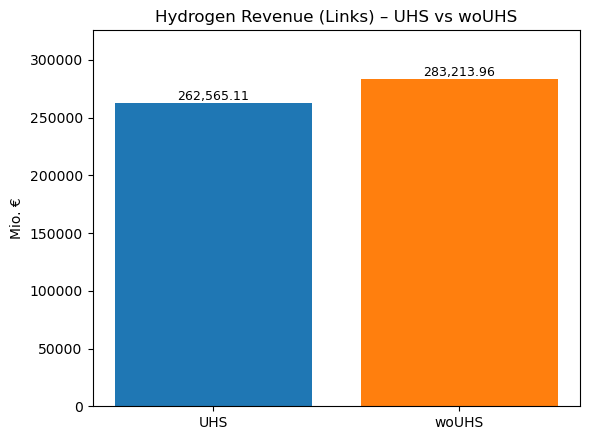

In [140]:
def hydrogen_revenue_mio(n: pypsa.Network) -> float:
    """
    Sum Revenue (€) for hydrogen-related Links (carrier contains 'H2').
    Works whether the index is MultiIndex with 'carrier' or a simple Index.
    Returns Mio. €.
    """
    revenue = n.statistics.revenue(comps=["Link"])  # Series in EUR
    idx = revenue.index

    if isinstance(idx, pd.MultiIndex):
        level = "carrier" if "carrier" in (idx.names or []) else idx.nlevels - 1
        carriers = idx.get_level_values(level).astype(str)
    else:
        carriers = pd.Index(idx).astype(str)

    mask = carriers.str.contains("H2", case=False, na=False)
    return float(revenue[mask].sum()) / 1e6  # -> Mio. €

#  Compute hydrogen revenue (Mio. €) 
uhs_h2_rev = round(hydrogen_revenue_mio(uhs), 2)
wouhs_h2_rev = round(hydrogen_revenue_mio(woUHS), 2)

#  Plot side-by-side bar chart 
labels = ["UHS", "woUHS"]
values = [uhs_h2_rev, wouhs_h2_rev]
colors = [SCENARIO_COLORS[l] for l in labels]

fig, ax = plt.subplots(figsize=(6, 4.5))
bars = ax.bar(labels, values, color=colors)
ax.set_title("Hydrogen Revenue (Links) – UHS vs woUHS")
ax.set_ylabel("Mio. €")
ax.set_ylim(0, max(values)*1.15 if max(values) > 0 else 1)

# Value labels
for rect, v in zip(bars, values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
            f"{v:,.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [141]:
# plot Hydrogen Market value, hydrogen costs, hydrogen exports (prices + quantity + revenue), hydrogen capacity for uhs and woUHS 2050 next to each other

##### Hydrogen Market

Hydrogen Market Value (UHS): 21.05 €
Hydrogen Market Value (woUHS): 21.09 €


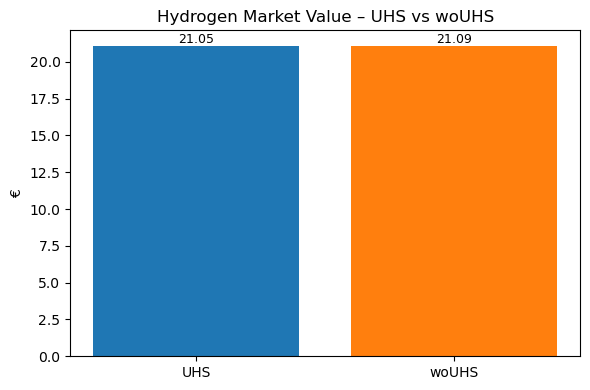

In [142]:
def hydrogen_market_value(n: pypsa.Network) -> float:
    """
    Extract yearly hydrogen market value for H2 Electrolysis (Link).
    Returns value in €.
    """
    stats = n.statistics()
    try:
        return float(stats.loc["Link", "H2 Electrolysis"]["Market Value"])
    except Exception:
        # fallback: filter revenue-like table if Market Value not in statistics() directly
        mv = n.statistics()
        idx = mv.index
        if isinstance(idx, pd.MultiIndex):
            if "carrier" in (idx.names or []):
                carriers = idx.get_level_values("carrier").astype(str)
            else:
                carriers = idx.get_level_values(-1).astype(str)
        else:
            carriers = pd.Index(idx).astype(str)
        mask = carriers.str.fullmatch(r"H2 Electrolysis", case=False, na=False)
        if "Market Value" in mv.columns:
            return float(mv.loc[mask, "Market Value"].sum())
        else:
            return float("nan")

#  Compute hydrogen market values 
uhs_mv = round(hydrogen_market_value(uhs), 2)
woUHS_mv = round(hydrogen_market_value(woUHS), 2)

print(f"Hydrogen Market Value (UHS): {uhs_mv} €")
print(f"Hydrogen Market Value (woUHS): {woUHS_mv} €")

#  Bar plot comparison 
labels = ["UHS", "woUHS"]
values = [uhs_mv, woUHS_mv]
colors = [SCENARIO_COLORS[l] for l in labels]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=colors)
ax.set_title("Hydrogen Market Value – UHS vs woUHS")
ax.set_ylabel("€")

for rect, v in zip(bars, values):
    if pd.notna(v):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                f"{v:,.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

##### Hydrogen costs

Hydrogen Cost per Unit (UHS): 21.05 Mio. € / TWh
Hydrogen Cost per Unit (woUHS): 21.09 Mio. € / TWh


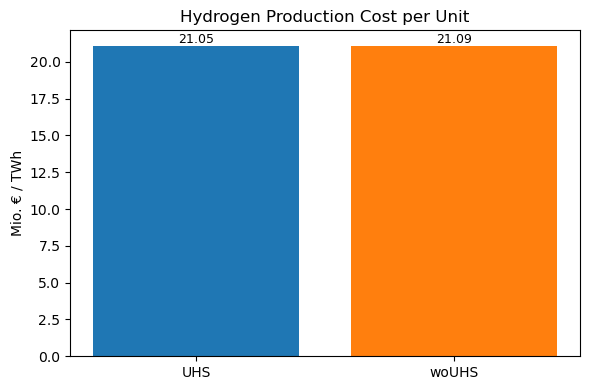

In [143]:
def hydrogen_cost_per_unit(n: pypsa.Network) -> float:
    """
    Compute hydrogen production cost per unit:
    (CAPEX + OPEX) / Supply
    Returns Mio. € / TWh.
    """
    stats = n.statistics()

    try:
        capex_mio = stats.loc["Link", "H2 Electrolysis"].loc["Capital Expenditure"] / 1e6
        opex_mio  = stats.loc["Link", "H2 Electrolysis"].loc["Operational Expenditure"] / 1e6
        supply_twh = stats.loc["Link", "H2 Electrolysis"].loc["Supply"].sum() / 1e6
    except Exception:
        capex = n.statistics.capex(comps=["Link"])
        opex  = n.statistics.opex(comps=["Link"])
        supply = n.statistics.supply(comps=["Link"], aggregate_time="sum")

        def carriers_of(idx):
            if isinstance(idx, pd.MultiIndex):
                lvl = "carrier" if "carrier" in (idx.names or []) else idx.nlevels - 1
                return idx.get_level_values(lvl).astype(str)
            return pd.Index(idx).astype(str)

        capex_mask = carriers_of(capex.index).str.fullmatch(r"H2 Electrolysis", case=False, na=False)
        opex_mask  = carriers_of(opex.index).str.fullmatch(r"H2 Electrolysis", case=False, na=False)
        sup_mask   = carriers_of(supply.index).str.fullmatch(r"H2 Electrolysis", case=False, na=False)

        capex_mio = float(capex[capex_mask].sum()) / 1e6
        opex_mio  = float(opex[opex_mask].sum()) / 1e6
        if isinstance(supply, pd.DataFrame):
            supply_twh = float(supply.loc[sup_mask].sum(numeric_only=True).sum()) / 1e6
        else:
            supply_twh = float(supply.loc[sup_mask].sum()) / 1e6

    total_mio = capex_mio + opex_mio
    return round(total_mio / supply_twh, 2) if supply_twh > 0 else float("nan")

#  Compute hydrogen cost per unit 
uhs_unit = hydrogen_cost_per_unit(uhs)
woUHS_unit = hydrogen_cost_per_unit(woUHS)

print(f"Hydrogen Cost per Unit (UHS): {uhs_unit} Mio. € / TWh")
print(f"Hydrogen Cost per Unit (woUHS): {woUHS_unit} Mio. € / TWh")

#  Bar plot comparison 
labels = ["UHS", "woUHS"]
values = [uhs_unit, woUHS_unit]
colors = [SCENARIO_COLORS[l] for l in labels]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=colors)
ax.set_title("Hydrogen Production Cost per Unit")
ax.set_ylabel("Mio. € / TWh")

for rect, v in zip(bars, values):
    if pd.notna(v):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                f"{v:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

##### Capacity

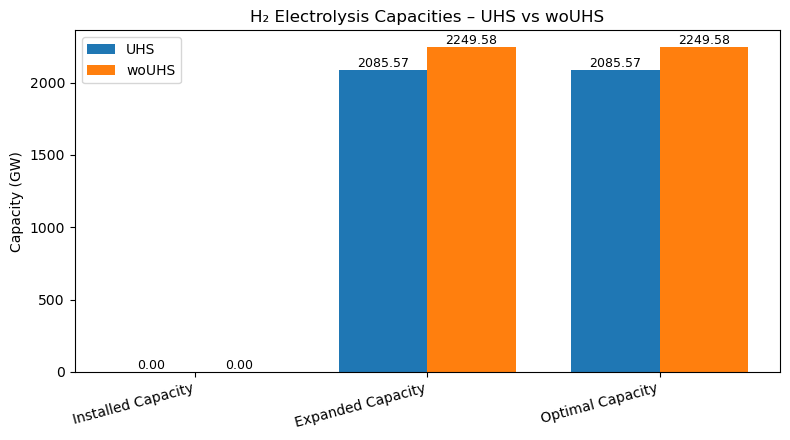

In [144]:
def _sum_h2_electrolysis(series_or_df) -> float:
    """
    Sum entries for carrier == 'H2 Electrolysis' (case-insensitive).
    Works for Series or DataFrame with simple or MultiIndex.
    Returns scalar.
    """
    idx = series_or_df.index
    if isinstance(idx, pd.MultiIndex):
        level = "carrier" if "carrier" in (idx.names or []) else idx.nlevels - 1
        carriers = idx.get_level_values(level).astype(str)
    else:
        carriers = pd.Index(idx).astype(str)

    mask = carriers.str.fullmatch(r"H2 Electrolysis", case=False, na=False)
    sel = series_or_df.loc[mask]
    return float(sel.sum() if isinstance(sel, pd.Series) else sel.sum(numeric_only=True).sum())

def h2_capacity_gw(n: pypsa.Network):
    """
    Returns (installed_GW, expanded_GW, optimal_GW) for H2 Electrolysis on Links.
    """
    inst = n.statistics.installed_capacity(comps="Link")  # MW
    expd = n.statistics.expanded_capacity(comps="Link")   # MW
    opti = n.statistics.optimal_capacity(comps="Link")    # MW

    inst_gw = _sum_h2_electrolysis(inst) / 1e3
    expd_gw = _sum_h2_electrolysis(expd) / 1e3
    opti_gw = _sum_h2_electrolysis(opti) / 1e3
    return inst_gw, expd_gw, opti_gw

#  Compute capacities (GW) 
uhs_inst, uhs_expd, uhs_opti = h2_capacity_gw(uhs)
woUHS_inst, woUHS_expd, woUHS_opti = h2_capacity_gw(woUHS)

#  Prepare grouped bar data 
categories = ["Installed Capacity", "Expanded Capacity", "Optimal Capacity"]
uhs_vals  = [uhs_inst,  uhs_expd,  uhs_opti]
wouhs_vals = [woUHS_inst, woUHS_expd, woUHS_opti]

x = np.arange(len(categories))
width = 0.38

fig, ax = plt.subplots(figsize=(8, 4.5))
b1 = ax.bar(x - width/2, uhs_vals,  width, label="UHS", color=SCENARIO_COLORS["UHS"])
b2 = ax.bar(x + width/2, wouhs_vals, width, label="woUHS", color=SCENARIO_COLORS["woUHS"])

ax.set_title("H₂ Electrolysis Capacities – UHS vs woUHS")
ax.set_ylabel("Capacity (GW)")
ax.set_xticks(x, categories, rotation=15, ha="right")
ax.legend()

# value labels
for bars in (b1, b2):
    for rect in bars:
        v = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, v, f"{v:.2f}",
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

##### Hourly Export Prices

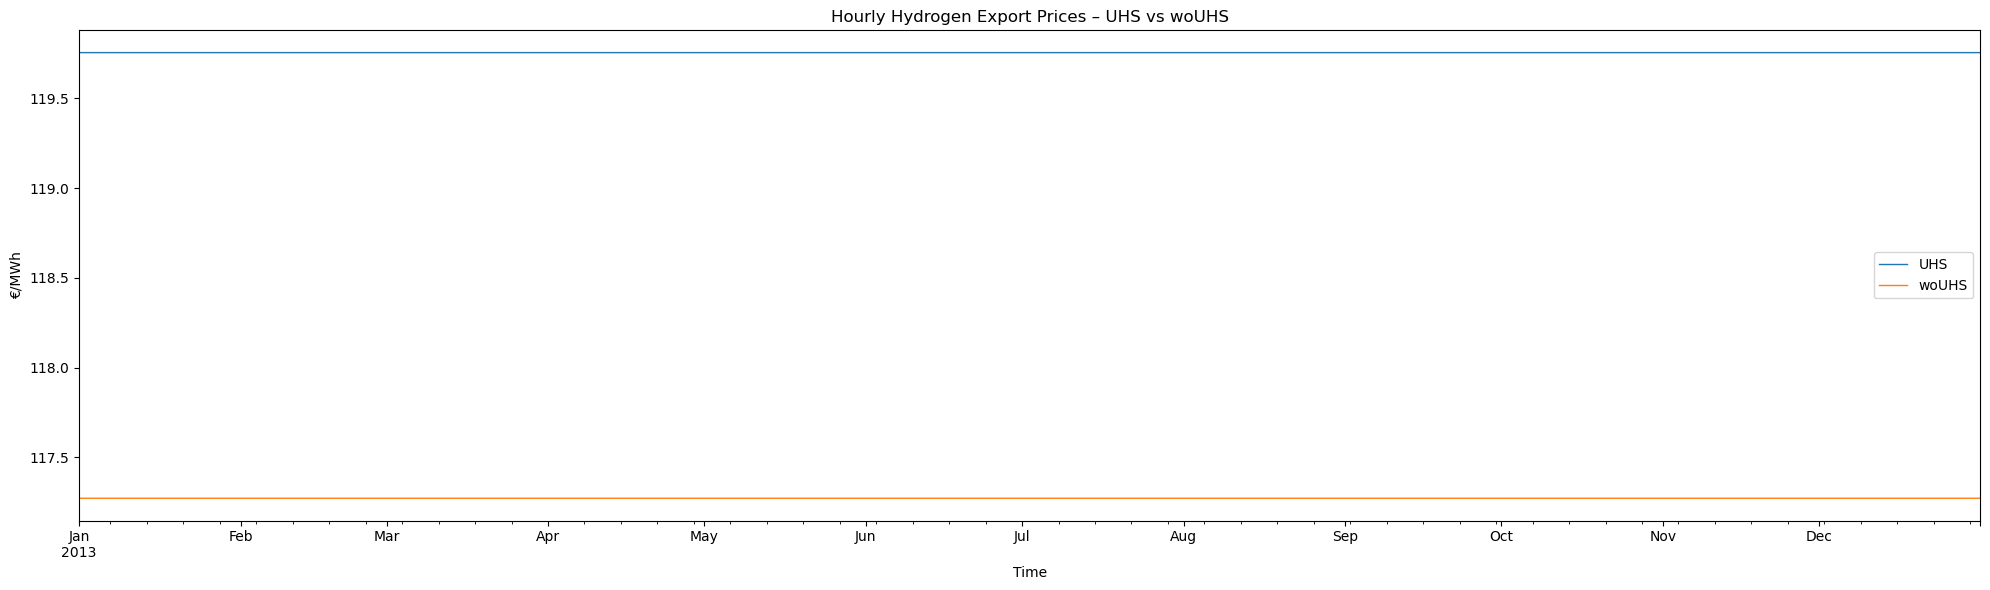

In [145]:
def get_h2_export_prices(n: pypsa.Network):
    """
    Extract hourly marginal prices for the hydrogen export bus.
    Returns a pandas Series with time index.
    """
    h2_buses = n.buses[n.buses.index.str.contains("H2", case=False)].index
    prices = n.buses_t.marginal_price[h2_buses]
    if "H2 export bus" in prices.columns:
        return prices["H2 export bus"]
    else:
        export_cols = [c for c in prices.columns if "export" in c.lower()]
        return prices[export_cols[0]] if export_cols else None

#  Extract hourly prices 
uhs_export_prices = get_h2_export_prices(uhs)
woUHS_export_prices = get_h2_export_prices(woUHS)

#  Plot both on the same axis 
fig, ax = plt.subplots(figsize=(20, 6))

uhs_export_prices.plot(ax=ax, lw=1, color=SCENARIO_COLORS["UHS"], label="UHS")
woUHS_export_prices.plot(ax=ax, lw=1, color=SCENARIO_COLORS["woUHS"], label="woUHS")

ax.set_title("Hourly Hydrogen Export Prices – UHS vs woUHS")
ax.set_xlabel("Time")
ax.set_ylabel("€/MWh")
ax.legend()

plt.tight_layout()
plt.show()

##### Hourly Export Quantity

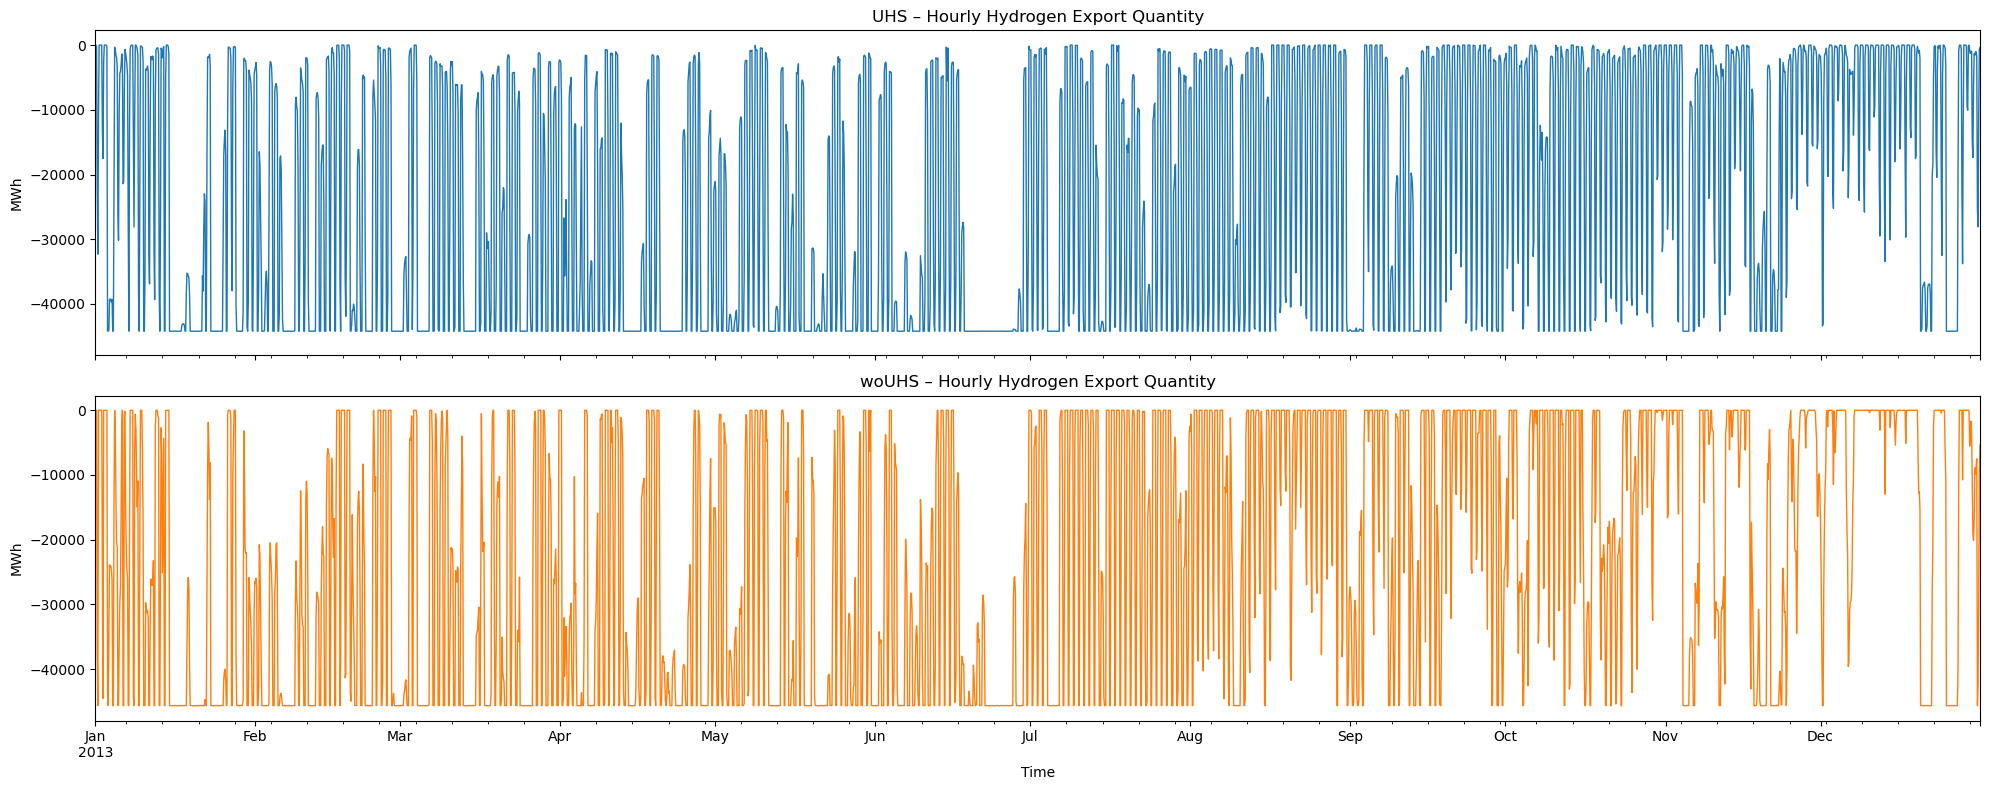

In [146]:
def get_h2_export_quantity(n: pypsa.Network):
    """
    Extract aggregated hourly hydrogen export quantity from H2 export links.
    Returns a pandas Series (time-indexed).
    """
    # Filter hydrogen links
    h2_links = n.links[n.links["carrier"].str.contains("H2", case=False, na=False)]
    if h2_links.empty:
        return None

    h2_q = n.links_t.p1[h2_links.index].copy()

    # Identify columns that represent exports (adjust pattern if needed)
    export_cols = [col for col in h2_q.columns if "export" in col.lower()]
    if not export_cols:
        return None

    # Sum all export flows into one series
    h2_q["H2 export"] = h2_q[export_cols].sum(axis=1)
    return h2_q["H2 export"]

#  Extract export quantities 
uhs_export_q = get_h2_export_quantity(uhs)
woUHS_export_q = get_h2_export_quantity(woUHS)

#  Plot side-by-side 
fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True, sharey=True)

if uhs_export_q is not None:
    uhs_export_q.plot(ax=axes[0], lw=1, color=SCENARIO_COLORS["UHS"])
    axes[0].set_title("UHS – Hourly Hydrogen Export Quantity")
    axes[0].set_ylabel("MWh")

if woUHS_export_q is not None:
    woUHS_export_q.plot(ax=axes[1], lw=1, color=SCENARIO_COLORS["woUHS"])
    axes[1].set_title("woUHS – Hourly Hydrogen Export Quantity")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("MWh")

plt.tight_layout()
plt.show()

In [147]:
# aggregate export quantitys to monthly sums and plot them for uhs and woUHS next to each other

In [148]:
# Plot uhs storage levels over the year

##### Hourly Export Revenue

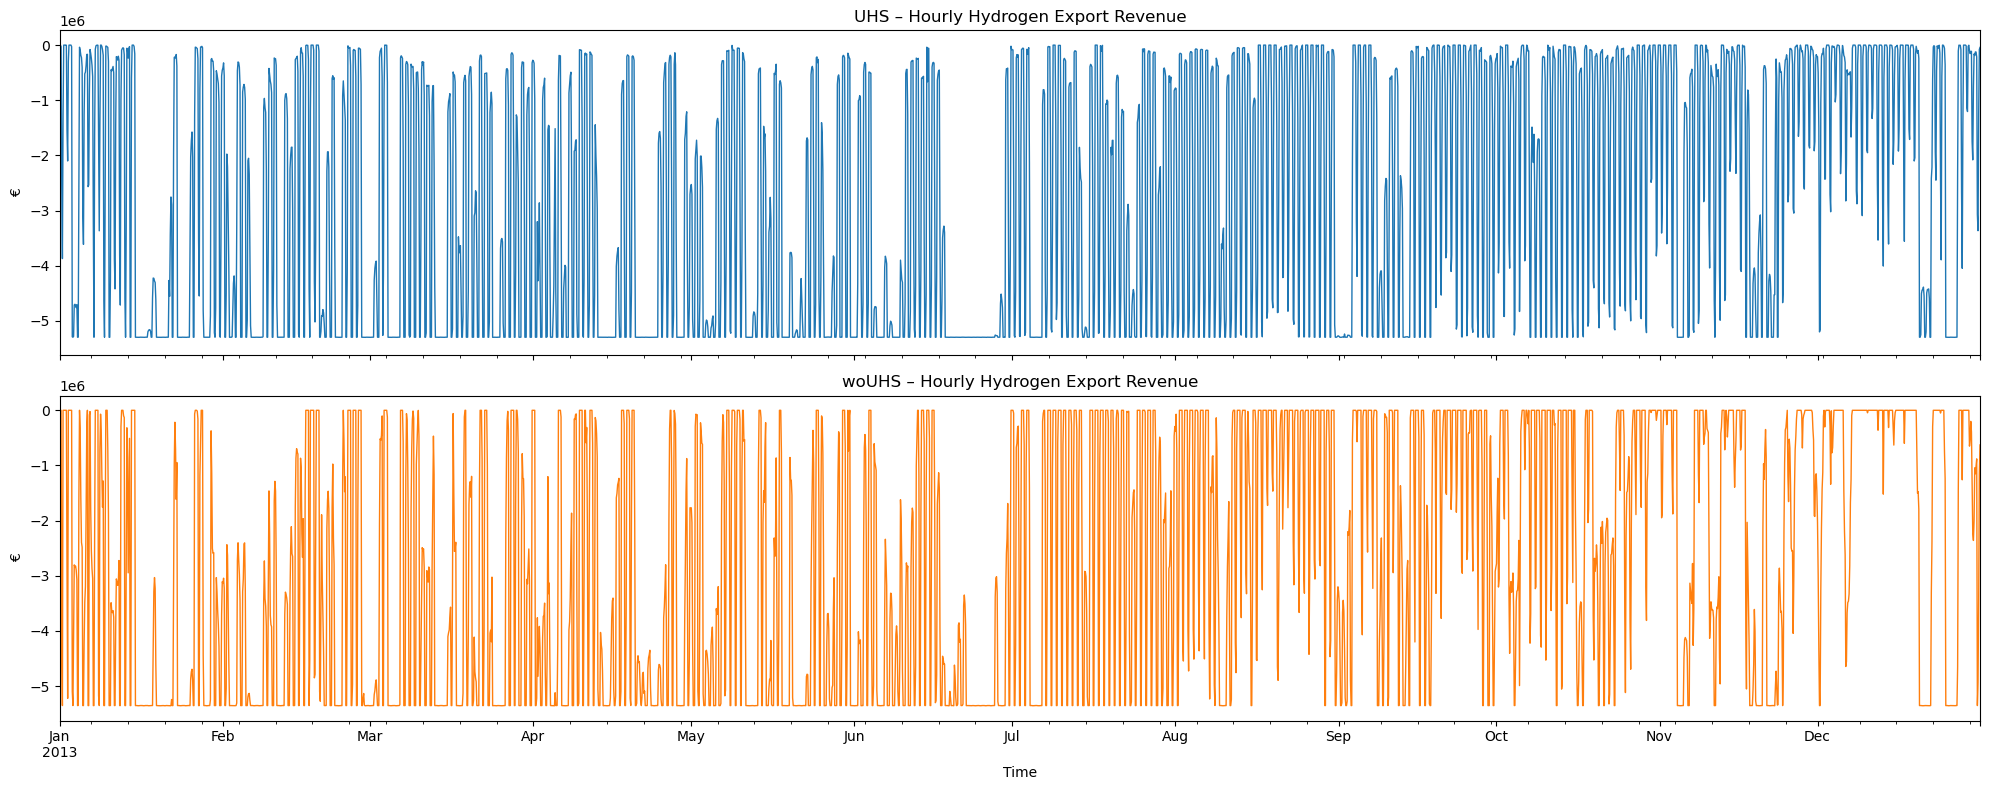

In [149]:
def get_h2_export_prices(n: pypsa.Network) -> pd.Series | None:
    """
    Return hourly marginal prices (€/MWh) for the hydrogen export bus.
    """
    h2_buses = n.buses[n.buses.index.str.contains("H2", case=False, na=False)].index
    if len(h2_buses) == 0:
        return None

    prices = n.buses_t.marginal_price[h2_buses]
    if "H2 export bus" in prices.columns:
        return prices["H2 export bus"]
    # fallback: first H2 bus containing 'export'
    export_cols = [c for c in prices.columns if "export" in c.lower()]
    return prices[export_cols[0]] if export_cols else None

def get_h2_export_quantity(n: pypsa.Network) -> pd.Series | None:
    """
    Return aggregated hourly H2 export quantity (MWh) by summing all export links.
    """
    h2_links = n.links[n.links["carrier"].str.contains("H2", case=False, na=False)]
    if h2_links.empty:
        return None

    q = n.links_t.p1[h2_links.index].copy()
    export_cols = [c for c in q.columns if "export" in c.lower()]
    if not export_cols:
        return None

    q["H2 export"] = q[export_cols].sum(axis=1)
    return q["H2 export"]

def hourly_export_revenue(n: pypsa.Network) -> pd.Series | None:
    """
    Compute hourly export revenue (€) = quantity (MWh) * price (€/MWh).
    Aligns indices safely.
    """
    price = get_h2_export_prices(n)
    qty   = get_h2_export_quantity(n)
    if price is None or qty is None:
        return None

    # Align by intersection of timestamps; reindex quantity to price index like your workflow
    idx = price.index.intersection(qty.index)
    if len(idx) == 0:
        return None

    qty_aligned = qty.reindex(idx)
    price_aligned = price.reindex(idx)
    revenue = qty_aligned * price_aligned  # €
    revenue.name = "Hourly Revenue (€)"
    return revenue

# Compute hourly export revenue series
uhs_rev = hourly_export_revenue(uhs)
wouhs_rev = hourly_export_revenue(woUHS)

# Plot side-by-side 
fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True, sharey=True)

if uhs_rev is not None:
    uhs_rev.plot(ax=axes[0], lw=1, color=SCENARIO_COLORS["UHS"])
    axes[0].set_title("UHS – Hourly Hydrogen Export Revenue")
    axes[0].set_ylabel("€")

if wouhs_rev is not None:
    wouhs_rev.plot(ax=axes[1], lw=1, color=SCENARIO_COLORS["woUHS"])
    axes[1].set_title("woUHS – Hourly Hydrogen Export Revenue")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("€")

plt.tight_layout()
plt.show()

In [150]:
# Show how hydrogen underground storage can both stabilize fluctuating hydrogen supply and better handle fluctuating demand (possibly with a graph showing supply/demand coverage with fluctuating supply and demand with/without hydrogen storage)

In [151]:
# Show how storage can have a price-stabilizing effect on both sides (exporting/importing countries)

In [152]:
# identify the LCOH of the deposits and investigating which ones have been selected

#### Show PV and Wind Potential

In [153]:
# Plot maps of PV and Wind Potential

#### Sensitivity Analysis

In [154]:
# Compare the use of underground hydrogen storage for UHS and woUHS 2050 with various spatial scenarios (1-10-24-100 nodes)

In [155]:
# compare price stabilizing effect results with and without temporal matching activated